In [1]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

In [2]:
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
    
    return sorted_eigenvalues, sorted_eigenvectors

In [3]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return np.abs(1/(factor*10**-6*der))

In [4]:
omega_c1 = 4.5*2*np.pi
g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
omega_c2 =  8.5*2*np.pi
g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi

In [5]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega,flux):
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    omegas = snail.omegas
    
    #cavity1 parameters
    
    
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters

    
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    snailcc = SNAILCC(snail,cavity1,cavity2)
    
    H0,Hc = snailcc.hamiltonian()
    energy,U = np.linalg.eigh(H0)
    U_dag = np.transpose(U.conjugate())
    Hc = U_dag @ Hc @ U
    H0 = U_dag @ H0 @ U
    H0 = H0 - H0[0][0]*np.identity(len(H0))
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    index12 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy)) - omega_c1 * np.ones(len(energy))))
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexsc1 = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexsc2 = np.argmin(np.abs(energy - (omegas+omega_c2) * np.ones(len(energy))))
    indexc12 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexc22 = np.argmin(np.abs(energy - 2 * omega_c2 * np.ones(len(energy))))
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = 2*np.pi/omega
#     H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=1000000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, 0),basis(total_dim, indexc11), basis(total_dim, indexc21),basis(total_dim, index12),
                   basis(total_dim, indexs1),basis(total_dim, indexsc1),basis(total_dim, indexsc2),
                   basis(total_dim, indexc12),basis(total_dim, indexc22)]
    
    
    max_overlap_indices = [0,0,0,0,0,0,0,0,0]
    max_overlaps = [0,0,0,0,0,0,0,0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    omega = 2*np.pi/T

    energyc1p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1p , omega/2/np.pi)
    energyc1p = energyc1p + k *omega/2/np.pi - energyg
    energyc2p = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, energyc2p, omega/2/np.pi)
    energyc2p = energyc2p + k *omega/2/np.pi - energyg
    
    omega12 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi+omega_c2/2/np.pi, omega12 , omega/2/np.pi)
    omega12 = omega12 +k *omega/2/np.pi - energyg
    
    diff = omega12 - energyc1p - energyc2p
    
    energys1 = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k(omegas/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    energysc1 = f_energies[max_overlap_indices[5]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc1, omega/2/np.pi)
    starkshift1 = energysc1 - energyg + k*omega/2/np.pi - energyc1p - energys1

    energysc2 = f_energies[max_overlap_indices[6]]/2/np.pi
    k = find_optimal_k((omega_c2+omegas)/2/np.pi, energysc2, omega/2/np.pi)
    starkshift2 = energysc2 - energyg + k*omega/2/np.pi - energyc2p - energys1
    
    energyc12 = f_energies[max_overlap_indices[7]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc12, omega/2/np.pi)
    energyc12 = energyc12 +k*omega/2/np.pi
    selfkerr1 = energyc12-energyg - 2*energyc1p
    
    energyc22 = f_energies[max_overlap_indices[8]]/2/np.pi
    k = find_optimal_k(2*omega_c2/2/np.pi, energyc22, omega/2/np.pi)
    energyc22 = energyc22 +k*omega/2/np.pi
    selfkerr2 = energyc22-energyg - 2*energyc2p

    return diff,energyc1p,energyc2p , starkshift1, starkshift2, selfkerr1, selfkerr2,energys1

In [6]:
## import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)
    
    return Hs,-1j*(s-sd),phi_zpf,c2
from qutip import propagator,floquet_modes,Qobj,Options,basis
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def energy_diff2(A,omega,phi_ex):
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    print(snail.g3/2/np.pi)
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    Hs,charge_op = snail.spectrum_charge()
    omegas = H0[1][1]-H0[0,0]
    
    #cavity1 parameters
#     omega_c1 = 7*2*np.pi
#     g_int1 = 0.15*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
#     omega_c2 = 3*2*np.pi
#     g_int2 = 0.15*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()
    
    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC/ snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2

    energy,U = np.linalg.eigh(H)
    energy,U = sort_eigenpairs(energy,U)
    energy = energy - energy[0]*np.ones(len(energy))
    omegas = snail.omegas
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    energys1 = energy[indexs1]
    indexs2 = np.argmin(np.abs(energy - (2*omegas ) * np.ones(len(energy))))
    anh = energy[indexs2] - 2*energys1
    
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    energyc11 = energy[indexc11]
    indexc12 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    energyc12 = energy[indexc12]
    indexsc11 = np.argmin(np.abs(energy - (energys1+energyc11) * np.ones(len(energy))))
    energysc11 = energy[indexsc11]
    starkshift11 = energysc11  - energyc11 - energys1
    selfkerr1 = energyc12 - 2*energyc11
    indexsc12 = np.argmin(np.abs(energy - (2*energyc11 + energys1+ 2*starkshift11 + 2*selfkerr1) * np.ones(len(energy))))
    energysc12 = energy[indexsc12]
    
    
    starkshift12 = energysc12  - 2*energyc11 - energys1 - 2*starkshift11 - 2*selfkerr1
    
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    energyc21 = energy[indexc21]
    indexc22 = np.argmin(np.abs(energy - 2 * omega_c2 * np.ones(len(energy))))
    energyc22 = energy[indexc22]
    indexsc21 = np.argmin(np.abs(energy - (omegas+omega_c2) * np.ones(len(energy))))
    energysc21 = energy[indexsc21]
    indexsc22 = np.argmin(np.abs(energy - (omegas+2*omega_c2) * np.ones(len(energy))))
    energysc22 = energy[indexsc22]
    
    starkshift21 = energysc21  - energyc21 - energys1
    selfkerr2 = energyc22 - 2*energyc21
    starkshift22 = energysc22  - 2*energyc21 - energys1 - 2*starkshift21 - 2*selfkerr2
    
    index12 = np.argmin(np.abs(energy - energyc11* np.ones(len(energy)) - energyc21 * np.ones(len(energy))))
    energy12 = energy[index12]
    index121 = np.argmin(np.abs(energy - (omega_c2+omega_c1+omegas) * np.ones(len(energy))))
    energy121 = energy[index121]
    crosskerr = energy12 - energyc11 - energyc21
    scrosskerr = energy121 - energyc11 - energyc21 - energys1 - starkshift11 - starkshift21
    return crosskerr, energyc11, energyc21,  starkshift11, starkshift21, selfkerr1, selfkerr2, starkshift12,starkshift22,scrosskerr,anh,energys1
#     return energys1,anh,energyc11,selfkerr1, starkshift11,starkshift12,energyc21,selfkerr2, starkshift21,starkshift22,crosskerr,scrosskerr

In [7]:
np.array(energy_diff2(0,5*2*np.pi,0.4058))/2/np.pi

0.05491960680068848


array([-1.40546824e-07,  4.49513173e+00,  8.50583533e+00,  2.08135458e-05,
       -2.58423130e-06,  4.74605660e-08,  4.07834820e-08, -1.69791862e-08,
        1.90286496e-07,  8.95408176e-08,  3.90252895e-03,  5.99618423e+00])

In [250]:
from joblib import Parallel, delayed
# omega = 5.92 * 2 * np.pi
# A = 0.003 * 2 * np.pi
# fluxs = np.linspace(0.412, 0.415, 100)

fluxs = np.linspace(0.4315, 0.4325, 200)
# Using joblib to parallelize the loo
undriven_result = Parallel(n_jobs=-1)(delayed(energy_diff2)(A, omega, flux) for flux in fluxs)
undriven_result1 = Parallel(n_jobs=-1)(delayed(energy_diff2)(A, omega, flux+1e-6) for flux in fluxs)
undriven_result = np.array(undriven_result)
undriven_result1 = np.array(undriven_result1)
undriven_der1 = (undriven_result1[:,1] - undriven_result[:,1])/1e-6
undriven_der2 = (undriven_result1[:,2] - undriven_result[:,2])/1e-6

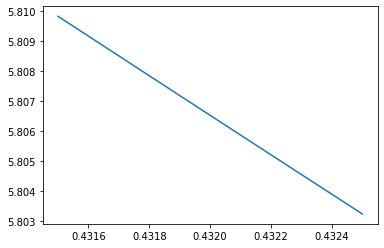

In [251]:
plt.plot(fluxs, undriven_result[:,-1]/2/np.pi)

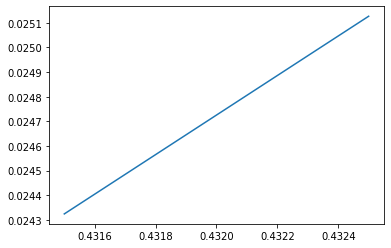

In [252]:
plt.plot(fluxs, undriven_result[:,-2]/2/np.pi)

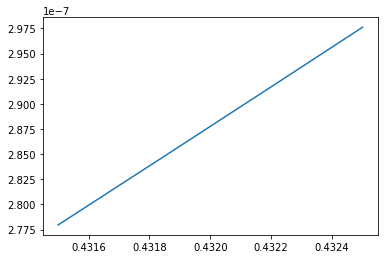

In [253]:
plt.plot(fluxs, undriven_result[:,0]/2/np.pi)
# plt.ylim(-1e-7,1e\-7)

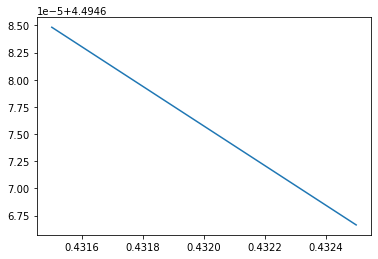

In [254]:
plt.plot(fluxs, undriven_result[:,1]/2/np.pi)

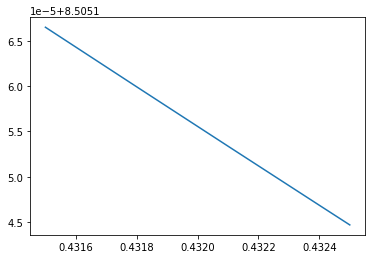

In [255]:
plt.plot(fluxs, undriven_result[:,2]/2/np.pi)

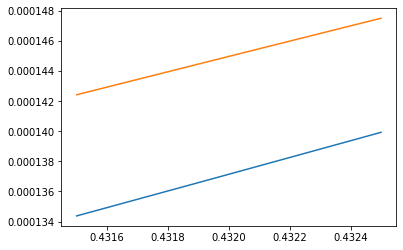

In [256]:
plt.plot(fluxs, undriven_result[:,3]/2/np.pi)
plt.plot(fluxs, undriven_result[:,4]/2/np.pi)
# plt.ylim(-1e-6,1e-6)

In [257]:
def app(A,omega,phi_ex):
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 100
    flux = 0.48
    N = 3
    dims = 10
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    dimc = 5
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(dimc)
    cd = creation(dimc)
    Ic = np.identity(dimc)
    Is = np.identity(dims)
    crosskerr, energyc11, energyc21,  starkshift11, starkshift21, selfkerr1, selfkerr2, starkshift12,starkshift22,scrosskerr,anh,energys1 =energy_diff2(A,omega,phi_ex)
    delta = energys1-omega 
    Hs = delta*sd@s +anh/2*sd@sd@s@s + A/2*(s+sd)/2/phi_zpf

    energies,U=np.linalg.eig(Hs)
    energies,U = sort_eigenpairs(energies,U)
    Ud = U.transpose().conjugate()
    Hs = np.kron(np.kron(np.diag(energies),Ic),Ic)
    
    Hc1 = energyc11*cd@c + selfkerr1/2*cd@cd@c@c
    Hc1 = np.kron(np.kron(Is,Hc1),Ic)
    Hc2 = energyc21*cd@c + selfkerr2/2*cd@cd@c@c
    Hc2 = np.kron(np.kron(Is,Ic),Hc2)
    H_int1 = starkshift11 * np.kron(Ud@sd@s@U,cd@c)+starkshift12/2* np.kron(Ud@sd@s@U,cd@cd@c@c)
    H_int1 = np.kron(H_int1,Ic)
    H_int2 = starkshift21 * np.kron(np.kron(Ud@sd@s@U,Ic),cd@c)+starkshift22/2* np.kron(np.kron(Ud@sd@s@U,Ic),cd@cd@c@c)
    H_int3 = crosskerr*np.kron(np.kron(Is,cd@c),cd@c) 
    
    H = Hs + Hc1 + Hc2 +H_int1+H_int2 + H_int3
    energy,U = np.linalg.eigh(H)

    # Compute the overlaps (absolute values of the first elements of the columns of U)
    overlaps = np.abs(U[0, :])**2

    # Find the index of the maximum overlap
    max_overlap_index = np.argmax(overlaps)
    energy = energy - energy[max_overlap_index]*np.ones(len(energy))
    overlaps = np.abs(U[dimc**2, :])**2

    # Find the index of the maximum overlap
    indexs1 = np.argmax(overlaps)
    energys1 = energy[indexs1]
    index12 = np.argmin(np.abs(energy - energyc11  * np.ones(len(energy)) - energyc21  * np.ones(len(energy))))
    
    indexc11 = np.argmin(np.abs(energy - energyc11 * np.ones(len(energy))))
    indexc12 = np.argmin(np.abs(energy - 2 * energyc11 * np.ones(len(energy))))
    indexsc11 = np.argmin(np.abs(energy - (delta+energyc11) * np.ones(len(energy))))
    energysc11 = energy[indexsc11]
    energyc11 = energy[indexc11]
    energyc12 = energy[indexc12]
    starkshift11 = energysc11  - energyc11 - energys1
    selfkerr1 = energyc12 - 2*energyc11
    indexc21 = np.argmin(np.abs(energy - energyc21 * np.ones(len(energy)))) 
    indexc22 = np.argmin(np.abs(energy - 2 * energyc21 * np.ones(len(energy))))
    indexsc21 = np.argmin(np.abs(energy - (delta+energyc21) * np.ones(len(energy))))
    energysc21 = energy[indexsc21]
    energyc21 = energy[indexc21]
    energyc22 = energy[indexc22]
    
    starkshift21 = energysc21  - energyc21 - energys1
    selfkerr2 = energyc22 - 2*energyc21
    
    
    
    energy12 = energy[index12]
    crosskerr = energy12 - energyc11 - energyc21
    return crosskerr/2/np.pi, energyc11/2/np.pi, energyc21/2/np.pi,  starkshift11/2/np.pi, starkshift21/2/np.pi, selfkerr1/2/np.pi, selfkerr2/2/np.pi

In [258]:
def app2(A,omega,phi_ex):
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 100
    flux = 0.48
    N = 3
    dims = 10
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    dimc = 5
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(dimc)
    cd = creation(dimc)
    Ic = np.identity(dimc)
    Is = np.identity(dims)
    crosskerr, energyc11, energyc21,  starkshift11, starkshift21, selfkerr1, selfkerr2, starkshift12,starkshift22,scrosskerr,anh,energys1 =energy_diff2(A,omega,phi_ex)
    delta = energys1-omega 
    Hs = delta*sd@s +anh/2*sd@sd@s@s + A/2/2/phi_zpf*(s+sd)

    energies,U=np.linalg.eig(Hs)
    energies,U = sort_eigenpairs(energies,U)
    deltap = energies[1]-energies[0]
    
    Ud = U.transpose().conjugate()
    g01 = (Ud@sd@s@U)[0,1]
    crosskerr = crosskerr-2*starkshift11*starkshift21/deltap*g01**2
    energyc11 = (energyc11+(Ud@sd@s@U)[0,0]*starkshift11)
    energyc21 = (energyc21+(Ud@sd@s@U)[0,0]*starkshift21)
    selfkerr1 = selfkerr1 - 2*starkshift11**2/deltap*g01**2
    selfkerr2 = selfkerr2 - 2*starkshift11**2/deltap*g01**2
    starkshift11 = ((Ud@sd@s@U)[1,1]-(Ud@sd@s@U)[0,0])*starkshift11
    starkshift21 = ((Ud@sd@s@U)[1,1]-(Ud@sd@s@U)[0,0])*starkshift21

    print(A/2/2/phi_zpf/2/np.pi)
    return crosskerr/2/np.pi,energyc11/2/np.pi, energyc21/2/np.pi,  starkshift11/2/np.pi, starkshift21/2/np.pi,selfkerr1/2/np.pi,selfkerr2/2/np.pi

In [259]:
omega = 5.8* 2 * np.pi
A = 0.003 * 2 * np.pi
appv = Parallel(n_jobs=-1)(delayed(app2)(A, omega, flux) for flux in fluxs)
appv = np.array(appv)

In [260]:
cross_kerrs = Parallel(n_jobs=-1)(delayed(app)(A, omega, flux) for flux in fluxs)
cross_kerrs1 = Parallel(n_jobs=-1)(delayed(app)(A, omega, flux+1e-5) for flux in fluxs)
cross_kerrs = np.array(cross_kerrs)
cross_kerrs1 = np.array(cross_kerrs1)
der1 = (cross_kerrs1[:,1] - cross_kerrs[:,1])/1e-5
der2 = (cross_kerrs1[:,2] - cross_kerrs[:,2])/1e-5

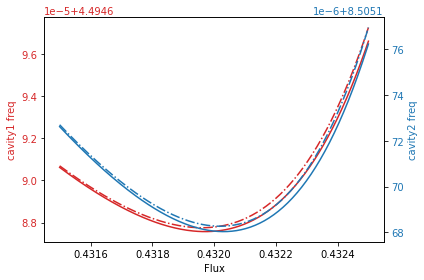

In [261]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 freq', color=color)
ax1.plot(fluxs, appv[:,1], '-.',color=color)
ax1.plot(fluxs, cross_kerrs[:, 1],color=color)
ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(7.004,7.0045)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 freq', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, appv[:, 2], '-.', color=color)
ax2.plot(fluxs, cross_kerrs[:, 2],color=color)
# ax2.set_ylim(2.9927,2.9928)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

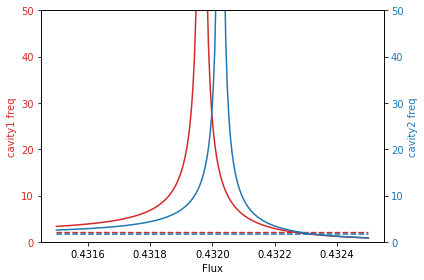

In [262]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 freq', color=color)
ax1.plot(fluxs, T1f(undriven_der1)/1e6, '--',color=color)
ax1.plot(fluxs, T1f(der1)/1e6/2/np.pi,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0,50)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 freq', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, T1f(undriven_der2)/1e6, '--', color=color)
ax2.plot(fluxs, T1f(der2)/1e6/2/np.pi,color=color)
ax2.set_ylim(0,50)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

In [263]:
T1f(undriven_der2)/1e6/(T1f(undriven_der1)/1e6)

array([0.82716344, 0.82722887, 0.82729201, 0.82735658, 0.827424  ,
       0.8274857 , 0.82755266, 0.82761926, 0.82768313, 0.82774917,
       0.8278131 , 0.8278776 , 0.82794289, 0.82800964, 0.82807437,
       0.82813844, 0.8282042 , 0.82827168, 0.82833716, 0.82839827,
       0.82846675, 0.82852952, 0.82859585, 0.82866021, 0.82872445,
       0.82879306, 0.82885706, 0.82892532, 0.82898733, 0.82905721,
       0.82911532, 0.82918483, 0.82925243, 0.82931478, 0.82937988,
       0.82944006, 0.8295078 , 0.82957736, 0.82963983, 0.8297041 ,
       0.82977109, 0.82983686, 0.82989961, 0.82996669, 0.83003606,
       0.83010127, 0.83016667, 0.83022953, 0.83029115, 0.83035962,
       0.83042328, 0.83049022, 0.83055723, 0.83062035, 0.83068644,
       0.83075022, 0.83081772, 0.83088178, 0.83094598, 0.83101495,
       0.83107836, 0.83114264, 0.83120801, 0.83127104, 0.83133781,
       0.83140641, 0.8314714 , 0.83153454, 0.83160113, 0.83166589,
       0.83173291, 0.83179829, 0.83186032, 0.83192928, 0.83199

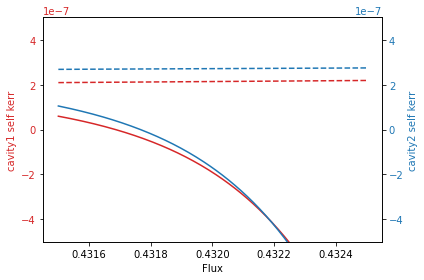

In [264]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 self kerr', color=color)
ax1.plot(fluxs, cross_kerrs[:, 5], color=color)
ax1.plot(fluxs, undriven_result[:, 5]/2/np.pi, '--',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 self kerr', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs[:, 6],color=color)
ax2.plot(fluxs, undriven_result[:, 6]/2/np.pi, '--',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-5e-7,5e-7)
ax2.set_ylim(-5e-7,5e-7)
fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

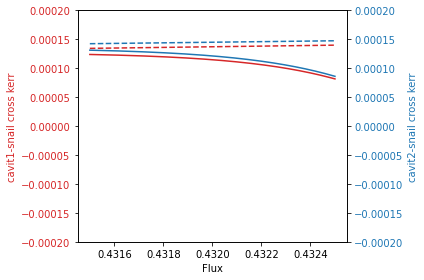

In [265]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavit1-snail cross kerr', color=color)
ax1.plot(fluxs, undriven_result[:, 3]/2/np.pi, '--',color=color)
ax1.plot(fluxs, cross_kerrs[:, 3], color=color)
ax1.set_ylim(-2e-4,2e-4)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavit2-snail cross kerr', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, undriven_result[:, 4]/2/np.pi, '--',color=color)
ax2.plot(fluxs, cross_kerrs[:, 4], color=color)
ax2.set_ylim(-2e-4,2e-4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

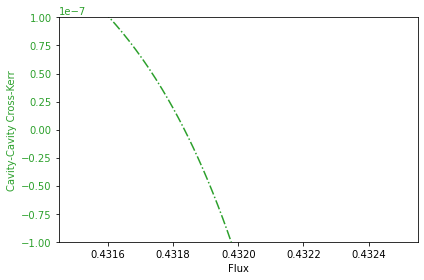

0.050084412881507105
0.048313389116647155
0.04651813991049745
0.04458493030867263
0.04902814642134017
0.048524046256274656
0.047573763015176
0.04602241146084867
0.04468967657668631
0.04923261932231744
[0.00215649]
0.04719549835566568
[0.00214916]
0.045517972918640355
[0.00214373]
0.04991700192972478
0.0485544343563042
0.04608944243240303
0.04994129713868316
0.04794271900933467
0.045750312278854184
0.046417660487700324
0.04573905903942817
0.045304196280245505
0.04612001829997341
0.04579920157959475
0.045365319057362255
0.04633215830062019
[0.0021463]
0.04610716930141711
[0.00214558]
0.04566481179481376
[0.00214418]
0.045297346527432475
[0.00214305]
0.04631238680608386
0.046047289961680074
0.04564453059439829
0.045263067959277384
0.04624859627277049
0.04605619645686548
0.045511198455152606
0.045823169716268285
0.045677200713898095
0.04552816332066194
0.045428344658239035
0.04573074561646467
0.045645211197104005
0.04548464883748081
0.045760391335483465
[0.00214448]
0.04566143806158651
[0.

0.04977637577879549
0.0468107210677906
0.04426696546329043
0.04929017298783074
0.047099444659410274
0.0499729724745874
[0.00215939]
0.04661605073673304
[0.00214722]
0.050139888010377096
0.04693966121127026
0.04561971756326467
0.04988523994627396
0.04753869452421774
0.045547428794949676
0.04625958669700508
0.04571883010791561
0.04540674641976
0.046417223066346644
0.045899880721980424
0.045399464919362774
0.04620667773800349
[0.0021459]
0.04572556990953557
[0.00214437]
0.046502878879816203
0.04571208254707335
0.04647234251629623
0.045808638856252304
0.04555874267325667
0.04527909549600669
0.04576488101729471
0.04567269525879424
0.04549417503379083
0.04582048276701748
0.045690265869630174
0.04555261188611659
0.045852273778559445
[0.00214477]
0.045724448810258125
[0.00214437]
0.04562084653185773
[0.00214405]
0.04548737314719961
[0.00214363]
0.045811971303691884
0.04565241554983583
0.04550551159515254
0.04580975429533306
0.04557795731377334
0.04891100844349886
0.046875275350720495
0.0448994

0.049405933916051435
0.04748007775636559
0.04561971756326467
0.050139519655878324
0.04638656561360546
0.044759605560570646
0.04943468147378261
[0.00215727]
0.04825271231980556
[0.00215285]
0.04608944243240303
[0.00214552]
0.050305337724337575
0.0475741757908806
0.0458220487157573
0.05008072470560555
0.047412951297889444
0.04578397713742566
0.04630578775892055
0.045806369159106415
0.04542039049623444
0.046377798358133916
0.04585294116968937
0.045515259393272965
0.04520767959402749
0.046113819542391736
[0.0021456]
0.04592710575462183
[0.00214501]
0.04557680226610667
[0.00214391]
0.04520126348597554
[0.00214276]
0.046113819542391736
0.04569183257066188
0.04535210333958802
0.04617578154023132
0.04573458952817891
0.04529964757481129
0.04573343900994419
0.045690710520857346
0.045555323919036585
0.045838403560176835
0.045615884454473635
0.04545289110065638
0.045798526632817686
[0.0021446]
0.045609560723750255
[0.00214401]
0.04546014911161858
[0.00214355]
0.04577834552377647
0.0456839624801059

0.04991700192972478
0.04719549835566568
0.04500346633969544
0.048822027751400224
0.048613879707522865
0.046810292155684434
0.04514115661647228
0.049492032620196
[0.00215749]
0.048614275103658594
[0.00215417]
0.04697178291673785
[0.0021484]
0.044760076746419214
[0.00214143]
0.049290554896716
0.047915983985812656
0.04527907293531767
0.049344497502241416
0.04830936701758487
0.04605175645150163
0.04454509684680482
0.04623314494329605
0.04572556990953557
0.045386268656114274
0.0462459321296495
0.04573186820136599
0.04649633541192749
[0.00214683]
0.0459338025371373
[0.00214503]
0.045427214414707866
[0.00214345]
0.046417660487700324
0.046013959874449895
0.045597141012160336
0.04523561570876348
0.04628161962015615
0.04604287456478721
0.04562651110641219
0.045258516708114364
0.04577834552377647
0.04566819320921463
0.045523632599097245
0.04575321171263579
0.045588784529065264
0.04548238439786648
0.04577609994527958
[0.00214453]
0.04560278581823821
[0.00214399]
0.04548510654355872
[0.00214363]
0.

0.04937715266066253
0.04697178291673785
0.044968831200642816
0.049057425526504946
0.04800791013056577
0.045551474142114586
0.04908705642338624
[0.00215594]
0.04819186057531146
[0.00215263]
0.04588916005216183
[0.00214489]
0.049945007845969745
0.048464355732201564
0.0461226748681814
0.04954544603500071
0.04821827192773989
0.04638264164783694
0.0446153910980792
0.046127101622236634
0.046013959874449895
0.04561745951672552
0.045221886169040236
0.04623270476418469
0.04589317795632715
0.04552205080994171
0.04648323990468405
[0.00214679]
0.045860103770567096
[0.0021448]
0.04647013614705142
0.04602729120537725
0.045508911876924685
0.046413303805194865
0.045721100418281965
0.04587016022144573
0.04565467081459525
0.04552137120555215
0.04584959364635936
0.04566549394221726
0.04556618002035087
0.04546877516507192
0.04581645462074186
[0.00214466]
0.04571770697008472
[0.00214435]
0.04556437053152145
[0.00214387]
0.04545333728773972
[0.00214353]
0.04578058889308236
0.045656934302792176
0.04553722455

0.050139888010377096
0.048464355732201564
0.046288194835712844
0.044302457080871584
0.04870333980167832
0.046452221498678774
0.050139888010377096
[0.00216006]
0.04779227864957917
[0.00215121]
0.0457884426465416
[0.00214457]
0.0499729724745874
0.04779227864957917
0.04588916005216183
0.0504384858064682
0.04815733007177979
0.04517147612870799
0.046213296376024
0.04596723732199152
0.045508911876924685
0.04648934858739057
0.0457386070277475
0.045372151317713896
0.04627939806159987
[0.00214613]
0.046053952529070026
[0.00214541]
0.04563776394862623
[0.0021441]
0.04533842557598018
[0.00214318]
0.04617355122227791
0.045873515385375284
0.04537260259431532
0.046347544673433716
0.04576827081641741
0.04585003579859859
0.04562761539917399
0.045498710332966215
0.04582945062833195
0.045726252681125124
0.04562265864505513
0.04548919363656381
0.04578731822431109
[0.00214457]
0.04563438476293666
[0.00214409]
0.04546468355059833
[0.00214356]
0.04577385999865421
0.045674945156027394
0.04553948694752995
0.0

0.049203582492869886
0.046746005571435066
0.044337921796310915
0.04873307354206957
0.04813044430310972
0.045483524959524915
0.04991700192972478
[0.00215917]
0.047885118550229144
[0.00215154]
0.04615586632897384
[0.00214573]
0.05027786928529876
0.04760546120813029
0.04437333838409151
0.04881849842109214
0.047881020298021236
0.0453430072599893
0.04643078956263901
0.04569183257066188
0.04535893663468459
0.04612666354267883
0.045839517865159225
0.045358491413720746
0.04634533799514714
[0.00214634]
0.045772739055863564
[0.00214452]
0.045304196280245505
[0.00214307]
0.04620005195664679
0.04591372325738046
0.04553609023249606
0.04649198743798376
0.045889176129909746
0.045470382482303895
0.04583436786499761
0.04561407199230528
0.04585406528979285
0.0456429530887334
0.04549598912806667
0.045785073152097434
[0.00214456]
0.045686211277267734
[0.00214425]
0.04557341829514335
[0.0021439]
0.04547602948554677
[0.0021436]
0.04579179970103875
0.045598272845474005
0.04542379866215969
0.04574245219994113

In [266]:
# Plotting the new data in a similar style with a different y-axis

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Flux')
ax1.set_ylabel('Cavity-Cavity Cross-Kerr', color=color)
ax1.plot(fluxs, cross_kerrs[:, 0],'-.',color=color, )
ax1.plot(fluxs, undriven_result[:, 0]/2/np.pi,color=color, )
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1e-7,1e-7)
fig.tight_layout()
plt.show()

In [543]:
cross_kerrs1 = Parallel(n_jobs=10)(delayed(energy_diff)(A, omega, flux) for flux in fluxs)
cross_kerrs1 = np.array(cross_kerrs1)

0.05504145918862506
0.05496994700455617
0.05512403801237093
0.05504621349629708
[0.00145608]
0.05496037513059621
[0.00145573]
0.05490518068173132
[0.00145551]
0.055091238073209856
0.055121701968234314
0.05502243730987375
0.055114600803366505
0.0550509590549929
[0.00145609]
0.054943607100210685
[0.00145567]
0.05508414052154755
0.054962770561008165
0.05503409083395647
0.05498667861439049
0.054986414905897264
0.05504145918862506
[0.00145606]
0.05497711884294184
[0.0014558]
0.054912395192796365
[0.00145554]
0.055077038402707855
0.05494120860103928
0.05502933809784087
0.05506282310558245
0.05497233780317535
0.055067303279790474
0.05496250538012842
0.05490010212129655
0.05499145195401357
[0.00145586]
0.05492681334828227
[0.0014556]
0.055074673050091866
0.05490999008664749
0.054993599038814574
0.054955347244746836
0.055105420210551974
0.05492681334828227
0.05501026809657227
0.05500576364761721
[0.00145591]
0.05497950885540857
0.05490036787740619
0.05497688067621434
0.05494096919839455
0.05499

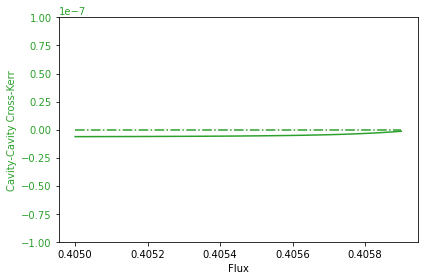

In [544]:
# Plotting the new data in a similar style with a different y-axis

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Flux')
ax1.set_ylabel('Cavity-Cavity Cross-Kerr', color=color)
ax1.plot(fluxs, cross_kerrs[:, 0],'-.',color=color, )
ax1.plot(fluxs, cross_kerrs1[:, 0],color=color, )
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1e-7,1e-7)
fig.tight_layout()
plt.show()

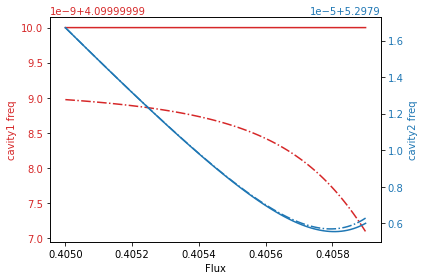

In [545]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 freq', color=color)
ax1.plot(fluxs, cross_kerrs1[:, 1], '-.',color=color)
ax1.plot(fluxs, cross_kerrs[:, 1],color=color)
ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(7.004,7.0045)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 freq', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs1[:, 2], '-.', color=color)
ax2.plot(fluxs, cross_kerrs[:, 2],color=color)
# ax2.set_ylim(2.9927,2.9928)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

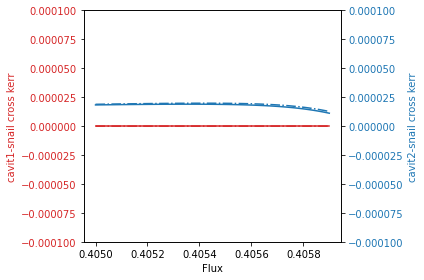

In [546]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavit1-snail cross kerr', color=color)
ax1.plot(fluxs, cross_kerrs1[:, 3], '-.',color=color)
ax1.plot(fluxs, cross_kerrs[:, 3], color=color)
ax1.set_ylim(-1e-4,1e-4)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavit2-snail cross kerr', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs1[:, 4], '-.',color=color)
ax2.plot(fluxs, cross_kerrs[:, 4], color=color)
ax2.set_ylim(-1e-4,1e-4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

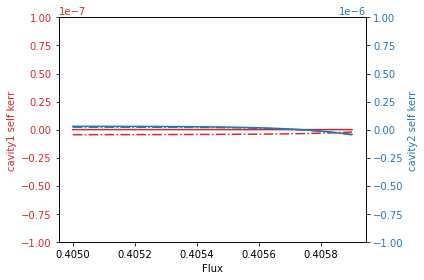

In [547]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 self kerr', color=color)
ax1.plot(fluxs, cross_kerrs[:, 5], color=color)
ax1.plot(fluxs, cross_kerrs1[:, 5], '-.',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 self kerr', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs[:, 6],color=color)
ax2.plot(fluxs, cross_kerrs1[:, 6], '-.',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1e-7,1e-7)
ax2.set_ylim(-1e-6,1e-6)
fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()